In [2]:
import random
import numpy as np
import os

import torch
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import cv2

import zipfile


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
import cv2

# 연속적인 부분 (폴리곤 - 삼각형, 사각형, 원) 을 찾는다. 
=> cv2.contour 주의: 0이라던가 128이라던가 이런 임의의 숫자를 지정하면 위험하다


In [ ]:
def get_input_image(image):
    # 이 함수는 손상된 이미지로부터 마스크를 생성하여 반환합니다.
    # 예시: 특정 조건에 따라 임의로 마스크 생성 (여기서는 단순히 모든 픽셀을 마스크로 가정)
    
    # 손상된 이미지의 그레이스케일 버전과 마스크 생성 (단순한 예제)
    image_gray = image.convert("L")
    mask = np.array(image_gray) > 128  # 임의의 임계값 기준으로 마스크 생성
    mask = Image.fromarray(mask.astype(np.uint8) * 255)  # 마스크 이미지를 PIL 형식으로 변환
    
    tmp_list = []
    for pix in np.array(image_gray):
        tmp_list.append(pix)
        if len(tmp_list) > 1 and tmp_list[-1] != pix:
            tmp_list = []
        
        if len(tmp_list) > 10:
            print(pix)
    
    return {
        'image_gray_masked': image_gray,
        'mask': transforms.ToTensor()(mask)  # 마스크를 텐서로 변환하여 사용
    }
    
damage_img = Image.open('data/train_input/TRAIN_00000.png').convert("RGB")
get_input_image(damage_img)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [5]:
damage_img = Image.open('data/train_input/TRAIN_00000.png').convert("RGB")
get_input_image(damage_img)

{'image_gray_masked': <PIL.Image.Image image mode=L size=512x512>,
 'mask': tensor([[[0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          ...,
          [0., 1., 1.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 0., 0.]]])}

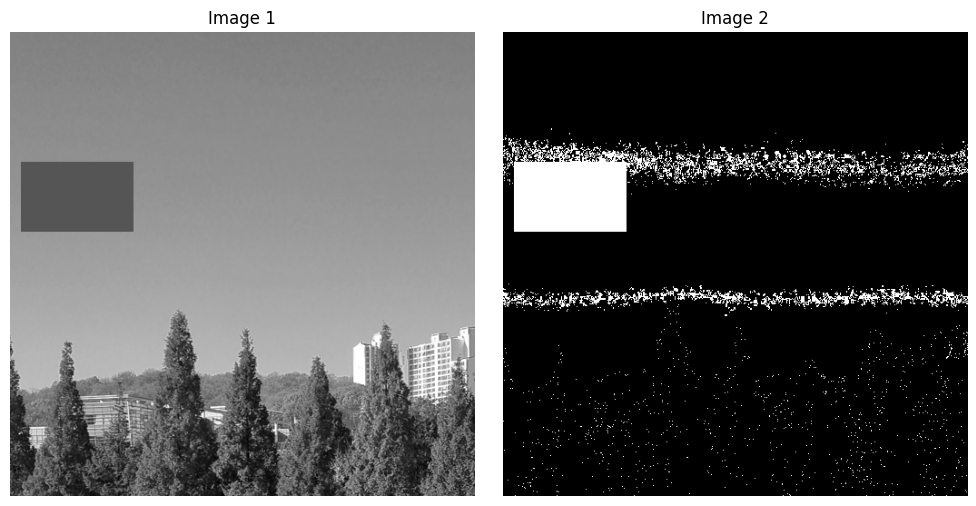

In [ ]:
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

def get_input_image(damage_img):
    image_gray_np = np.array(damage_img)
    
    # 연속된 동일 픽셀 값 탐색
    tmp_list = []
    pix_list = []

    for row in image_gray_np:
        for pix in row:
            # 이전 값과 연속적으로 같지 않으면 초기화
            if len(tmp_list) > 1 and tmp_list[-1] != pix:
                tmp_list = []
            
            tmp_list.append(pix)

            # 만약 같은 값이 연속적으로 20개 이상이면 리스트에 추가
            if len(tmp_list) > 20:
                pix_list.append(pix)

    # 특정 조건에 맞는 픽셀 변경
    # True로 사용하고 싶은 값들을 리스트로 지정
    target_values = list(set(pix_list))
    mask = np.isin(image_gray_np, target_values)  # target_values에 포함된 값만 True로 설정

    # 마스크를 이용해 값 변경
    image_gray_np[mask] = 255  # target_values에 해당하는 값은 0으로
    image_gray_np[~mask] = 0  # 나머지 값은 255로 설정

    # numpy 배열을 다시 PIL 이미지로 변환
    modified_image = Image.fromarray(image_gray_np)
    
    return modified_image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_num = '00103'
image_path = f'data/train_input/TRAIN_{img_num}.png'

# 테스트 코드
damage_img = Image.open(image_path)
result = get_input_image(damage_img)

# 2열로 출력
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1행 2열의 서브플롯 생성

# 첫 번째 이미지 표시
axes[0].imshow(damage_img, cmap='gray')
axes[0].set_title("Image 1")  # 첫 번째 이미지 제목
axes[0].axis("off")  # 축 숨기기

# 두 번째 이미지 표시
axes[1].imshow(result, cmap='gray')
axes[1].set_title("Image 2")  # 두 번째 이미지 제목
axes[1].axis("off")  # 축 숨기기

# 전체 출력
plt.tight_layout()
plt.show()


damage_img : PIL 이미지 크기 (Width x Height): (512, 512)
gray_image : PIL 이미지 크기 (Width x Height): (512, 512)
damage_img : PIL 이미지 모드: L
gray_image : PIL 이미지 모드: L
damage_img_np : NumPy 배열 크기 (Height x Width x Channels): (512, 512)
damage_img_np : 채널 수: 1 (Grayscale)
gray_image_np : NumPy 배열 크기 (Height x Width x Channels): (512, 512)
gray_image_np : 채널 수: 1 (Grayscale)


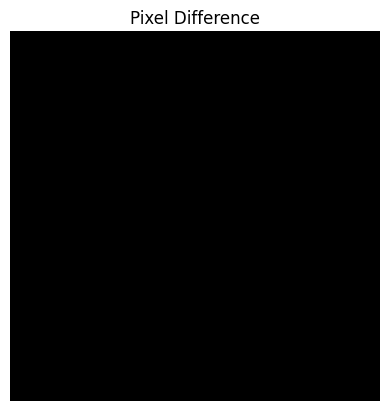

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2

img_num = '00103'
damage_image_path = f'data/train_input/TRAIN_{img_num}.png'
color_image_path = f'data/train_gt/TRAIN_{img_num}.png'

# 손생된 이미지와 컬러이미지 가져오기기
damage_img = Image.open(image_path)
color_image = Image.open(color_image_path)

# 흑백으로 변환
damage_img = damage_img.convert("L") 
gray_image = color_image.convert("L")  # "L"은 8비트 흑백 모드

# PIL 이미지를 NumPy 배열로 변환
damage_img_np = np.array(damage_img)
gray_image_np = np.array(gray_image)

# PIL 이미지 정보
print("damage_img : PIL 이미지 크기 (Width x Height):", damage_img.size)  # PIL에서는 (Width, Height)
print("gray_image : PIL 이미지 크기 (Width x Height):", gray_image.size)  # PIL에서는 (Width, Height)
print("damage_img : PIL 이미지 모드:", damage_img.mode)  # 이미지 모드(RGB, L 등)
print("gray_image : PIL 이미지 모드:", gray_image.mode)  # 이미지 모드(RGB, L 등)

# NumPy 배열 정보
print("damage_img_np : NumPy 배열 크기 (Height x Width x Channels):", damage_img_np.shape)
if len(damage_img_np.shape) == 2:
    print("damage_img_np : 채널 수: 1 (Grayscale)")
elif len(damage_img_np.shape) == 3:
    print(f"damage_img_np : 채널 수: {damage_img_np.shape[2]}")
    
print("gray_image_np : NumPy 배열 크기 (Height x Width x Channels):", gray_image_np.shape)
if len(gray_image_np.shape) == 2:
    print("gray_image_np : 채널 수: 1 (Grayscale)")
elif len(gray_image_np.shape) == 3:
    print(f"gray_image_np : 채널 수: {gray_image_np.shape[2]}")

# 두 이미지의 차이 계산
difference = cv2.absdiff(damage_img_np, gray_image_np)

# 결과 출력
plt.imshow(difference, cmap="gray")
plt.title("Pixel Difference")
plt.axis("off")
plt.show()


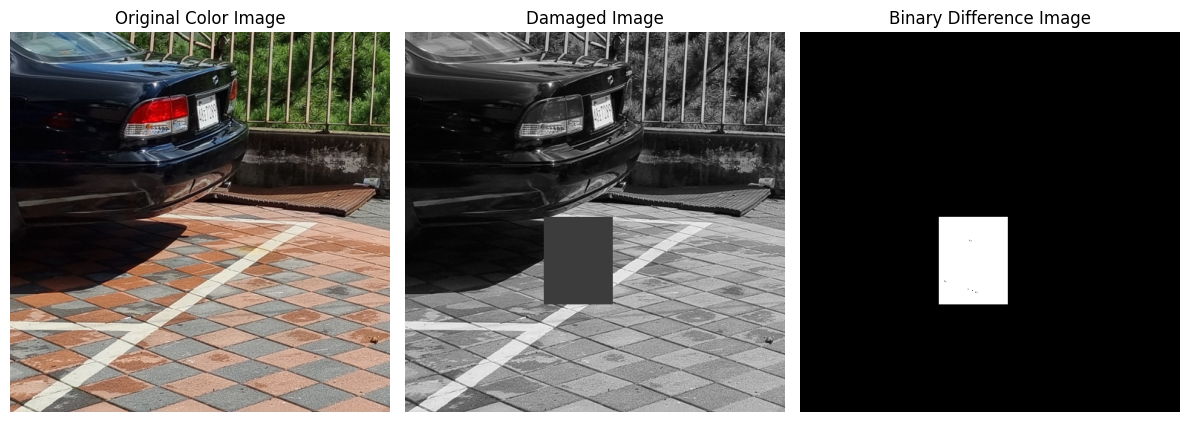

In [51]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2

img_num = '00001'
damage_image_path = f'data/train_input/TRAIN_{img_num}.png'
color_image_path = f'data/train_gt/TRAIN_{img_num}.png'

# OpenCV로 이미지 읽기 (NumPy 배열로 읽음)
color_image = cv2.imread(color_image_path)
gray_image = cv2.imread(damage_image_path, cv2.IMREAD_GRAYSCALE)  # 흑백 이미지로 읽기

# 색상 이미지를 흑백으로 변환 (PIL로 변환 후 NumPy로 변환)
color_image_gray = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

# 두 이미지의 차이 계산
difference = cv2.absdiff(color_image_gray, gray_image)

# 차이 값을 임계값으로 처리하여 이진화 이미지 생성
_, binary_difference = cv2.threshold(difference, 1, 255, cv2.THRESH_BINARY)

# numpy 배열을 다시 PIL 이미지로 변환
result_image = Image.fromarray(binary_difference)
result_image

# 결과를 시각화
plt.figure(figsize=(12, 6))

# 원본 컬러 이미지
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
plt.title("Original Color Image")
plt.axis("off")

# 손상된 이미지
plt.subplot(1, 3, 2)
plt.imshow(gray_image, cmap="gray")
plt.title("Damaged Image")
plt.axis("off")

# 차이 이미지 (이진화)
plt.subplot(1, 3, 3)
plt.imshow(binary_difference, cmap="gray")
plt.title("Binary Difference Image")
plt.axis("off")

plt.tight_layout()
plt.show()


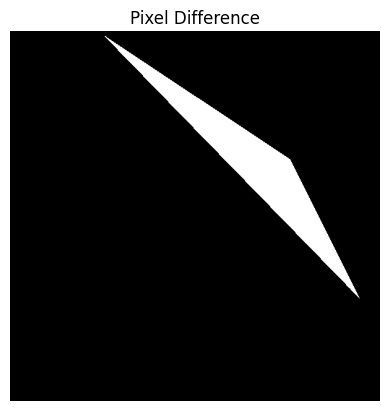

{'image_gray_masked': <PIL.Image.Image image mode=L size=512x512 at 0x1AFD84CDC10>, 'mask': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])}


In [55]:
def get_input_image(damage_img_path, origin_img_path):
    # OpenCV로 이미지 읽기 (NumPy 배열로 읽음)
    color_image = cv2.imread(origin_img_path)
    gray_image = cv2.imread(damage_img_path, cv2.IMREAD_GRAYSCALE)  # 흑백 이미지로 읽기
    
    # 색상 이미지를 흑백으로 변환 (PIL로 변환 후 NumPy로 변환)
    color_image_gray = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
    
    # 두 이미지의 차이 계산
    difference = cv2.absdiff(color_image_gray, gray_image)
    
    # 차이 값을 임계값으로 처리하여 이진화 이미지 생성
    _, binary_difference = cv2.threshold(difference, 1, 255, cv2.THRESH_BINARY)

    # 마스크 생성
    mask = binary_difference > 0  # 차이가 있는 부분을 마스크로 설정
    mask = Image.fromarray(mask.astype(np.uint8) * 255)  # 마스크 이미지를 PIL 형식으로 변환
    
    plt.imshow(mask, cmap="gray")
    plt.title("Pixel Difference")
    plt.axis("off")
    plt.show()

    return {
        'image_gray_masked': Image.fromarray(gray_image),  # 손상된 이미지를 PIL 이미지로 반환
        'mask': transforms.ToTensor()(mask)  # 마스크를 텐서로 변환하여 사용
    }


img_num = '00109'
damage_image_path = f'data/train_input/TRAIN_{img_num}.png'
color_image_path = f'data/train_gt/TRAIN_{img_num}.png'

# 손생된 이미지와 컬러이미지 가져오기기
damage_img = Image.open(image_path).convert("L")
color_image = Image.open(color_image_path).convert("RGB")

test = get_input_image(damage_image_path, color_image_path)
print(test)

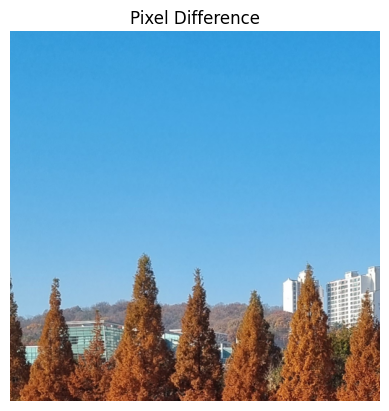

In [42]:
# 결과 출력
plt.imshow(color_image, cmap="gray")
plt.title("Pixel Difference")
plt.axis("off")
plt.show()

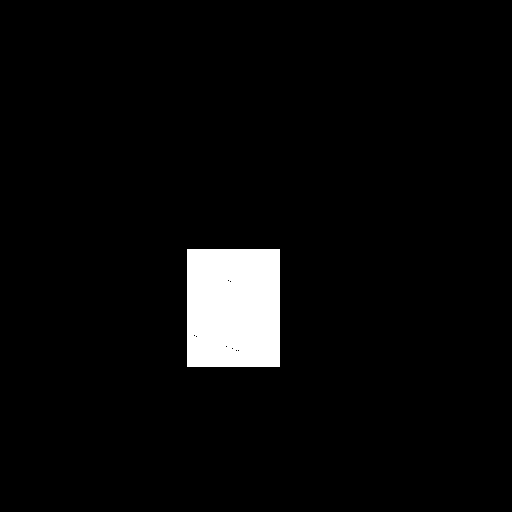

In [36]:
# numpy 배열을 다시 PIL 이미지로 변환
result_image = Image.fromarray(binary_difference)
result_image

In [ ]:
gray_damaged = train_input
gray_gt = train_gt => 흑백
cv2.absdiff(gray_damaged, gray_gt)
mask = threshold ()
matplot show mask



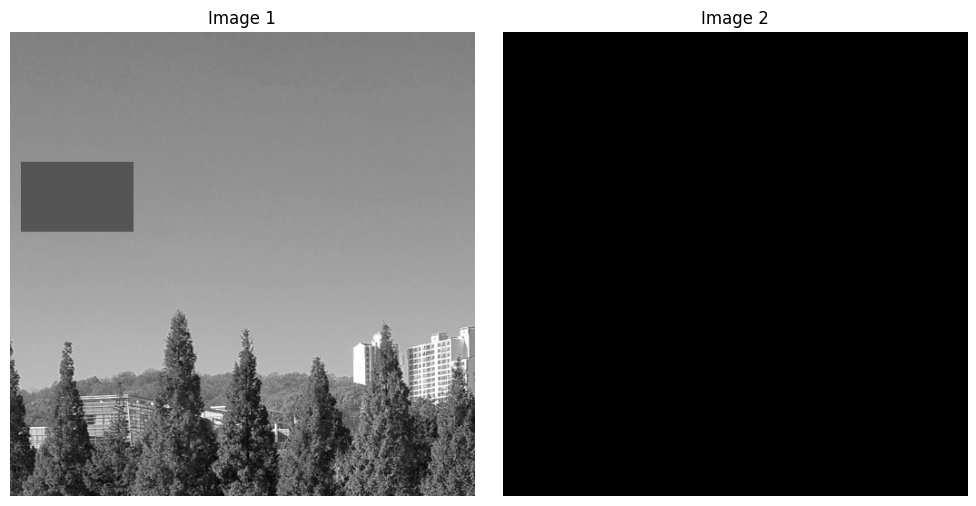

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_num = '00103'
image_path = f'data/train_input/TRAIN_{img_num}.png'

# 테스트 코드
damage_img = Image.open(image_path)
result = get_input_image(damage_img)

# 2열로 출력
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1행 2열의 서브플롯 생성

# 첫 번째 이미지 표시
axes[0].imshow(damage_img, cmap='gray')
axes[0].set_title("Image 1")  # 첫 번째 이미지 제목
axes[0].axis("off")  # 축 숨기기

# 두 번째 이미지 표시
axes[1].imshow(result, cmap='gray')
axes[1].set_title("Image 2")  # 두 번째 이미지 제목
axes[1].axis("off")  # 축 숨기기

# 전체 출력
plt.tight_layout()
plt.show()

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [ ]:
# !pip install matplotlib
# !pip install --upgrade numpy torch
# !pip uninstall torch
# !pip install torch --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu


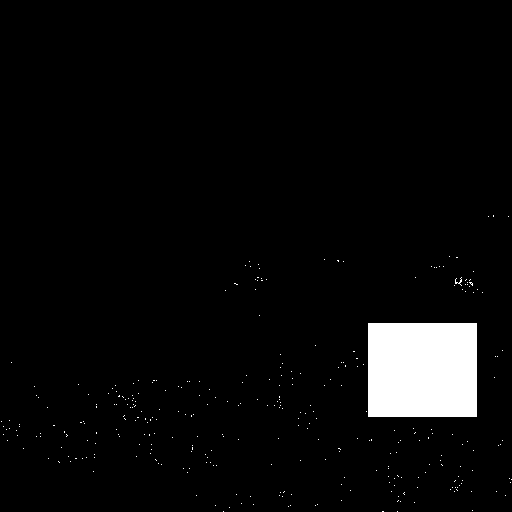

In [15]:
pre_img = Image.open('TRAIN_00000_modified.png')
pre_img

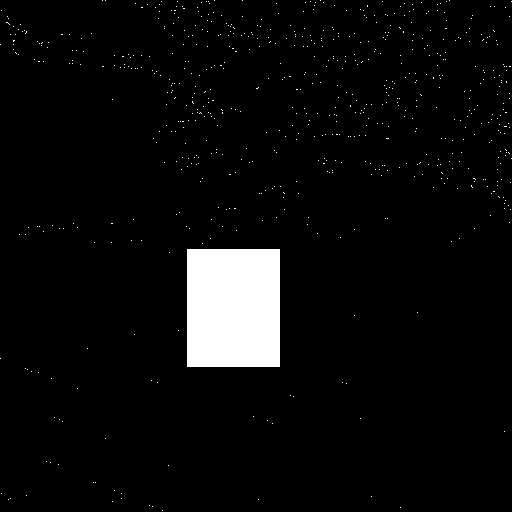

In [13]:
pre_img00001 = Image.open('TRAIN_00001_modified.png')
pre_img00001

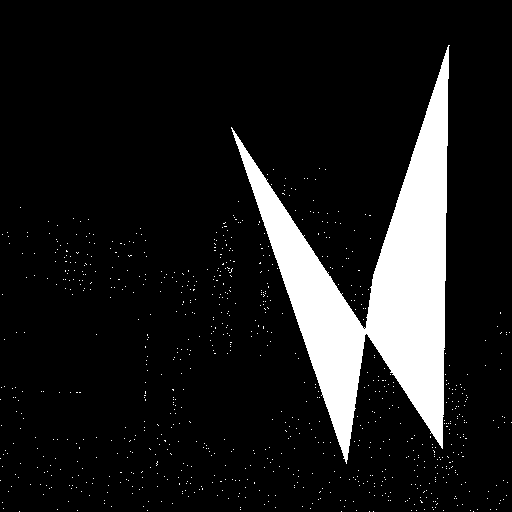

In [17]:
pre_img00001 = Image.open('TRAIN_00002_modified.png')
pre_img00001

In [27]:
20/512

0.0390625

In [2]:
from PIL import Image

def check_image_channels(image_path):
    try:
        img = Image.open(image_path)
        # 모드 확인 (예: 'RGB', 'L', 'RGBA' 등)
        mode = img.mode
        if mode == "RGB":
            print(f"The image {image_path} has 3 channels (RGB).")
        elif mode == "L":
            print(f"The image {image_path} has 1 channel (Grayscale).")
        elif mode == "RGBA":
            print(f"The image {image_path} has 4 channels (RGBA).")
        else:
            print(f"The image {image_path} has an unknown mode: {mode}.")
    except Exception as e:
        print(f"Error checking image channels: {e}")

# Example usage
check_image_channels(r"data\test_input\TEST_000.png")


The image data\test_input\TEST_000.png has 1 channel (Grayscale).


In [3]:
check_image_channels(r"data\train_input\TRAIN_00000.png")

The image data\train_input\TRAIN_00000.png has 1 channel (Grayscale).
